In [10]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import KFold
np.random.seed(2147483648)
import plotly.io as pio
#pio.renderers.default='browser'
import plotly.graph_objects as go


In [11]:
two_composite_filtered = pd.read_csv("../Curated_data/two_composite_filtered.csv", low_memory=False)


In [12]:
pio.renderers.default='notebook'


C:\Users\flea0265\AppData\Local\Temp\ipykernel_14044\358685020.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\flea0265\AppData\Local\Temp\ipykernel_14044\358685020.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- Iteration 0, MSE: 0.396
- Iteration 1000, MSE: 0.018


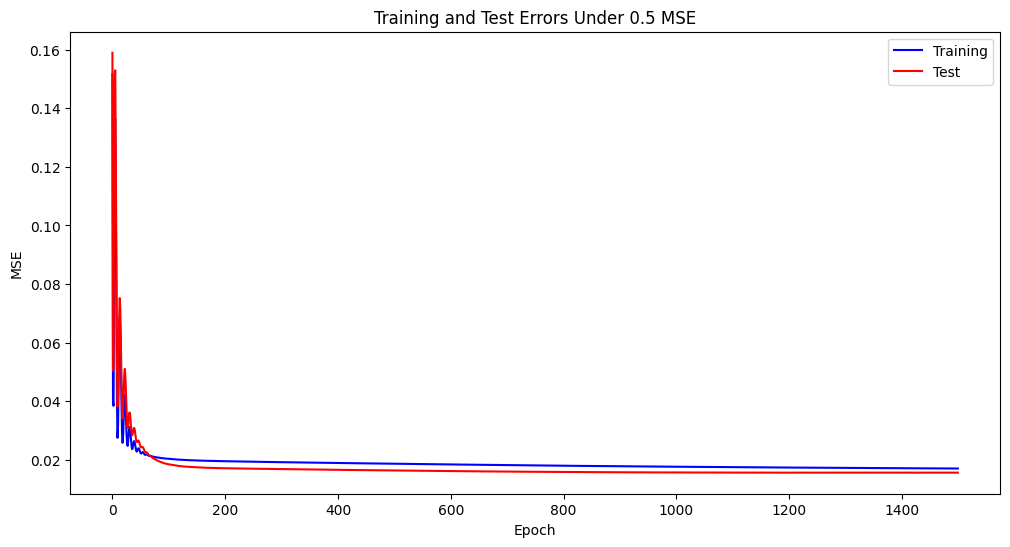

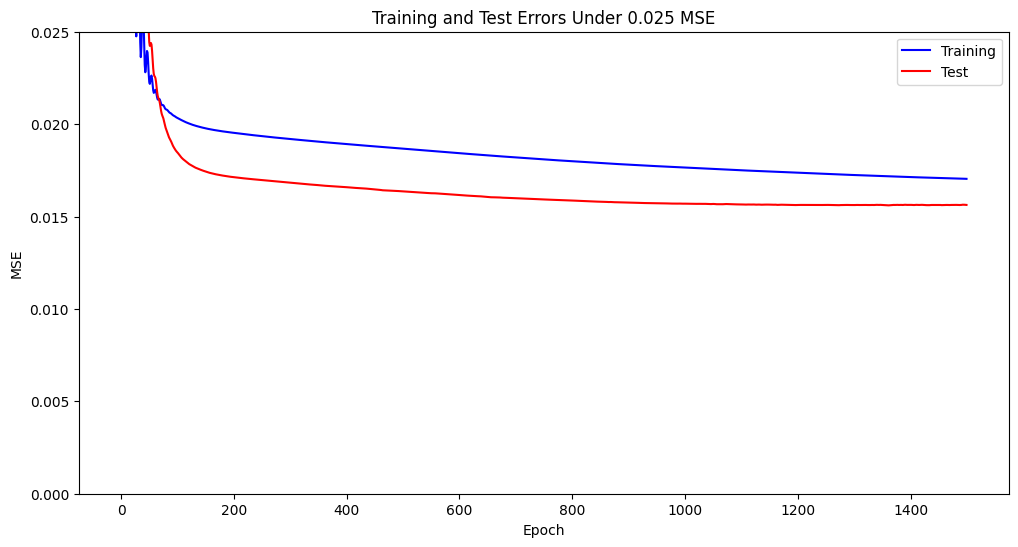

In [19]:
np.random.seed(42)
torch.manual_seed(42)


# #Subset data for each mineral
# mineral = 'Density_gcm3'
# two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
# two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])


# # Define the specific hole you want to predict for
# hole_name = 'KV-NME001'


# # Filter the data for the selected hole
# hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]

mineral = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
hole = 'KV139'

#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', mineral] + covariates
two_composite_1mineral = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral] + covariates)
hole_data = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = hole_data[columns_to_normalize].min()

for column in columns_to_normalize:
    hole_data[column] = hole_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = hole_data[columns_to_normalize].min().min()
max_values = hole_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
hole_data.loc[:, [mineral]] = scaler.fit_transform(hole_data.loc[:, [mineral]])


# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x = hole_data[['X','Y', 'Z']].values#[:,np.newaxis] makes the second dimension explicit
y = hole_data[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]




# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    nn.Linear(in_features=3, out_features=3000),
    nn.ReLU(),
    nn.Linear(in_features=3000, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(1500):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()



# Define a grid of points for prediction (including X, Y, and Z)
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 60)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 6)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(60, 6, 100)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)


fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='BrBG_r',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='BrBG_r',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y.data.numpy().ravel()]

))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
fig.write_html('tmp.html', auto_open=True)
#fig.show()




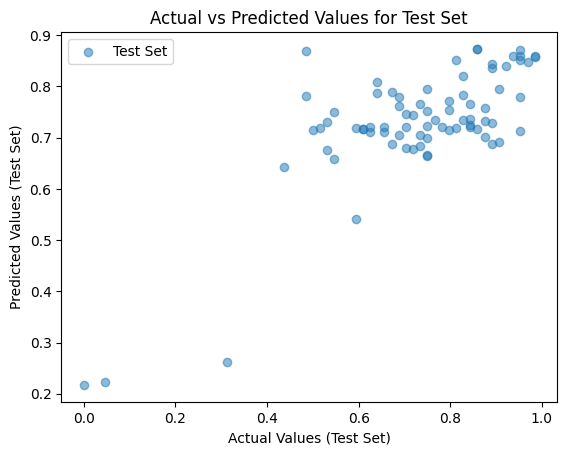

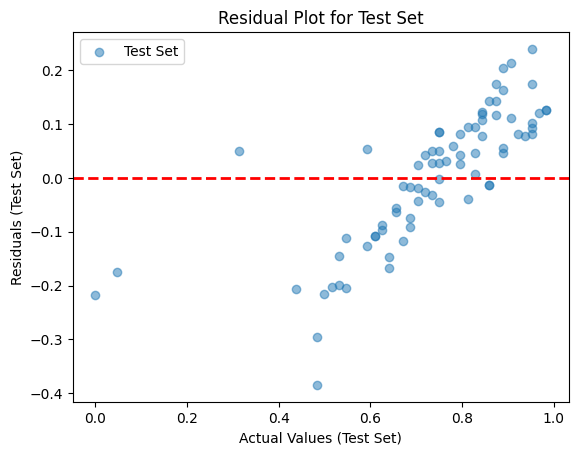

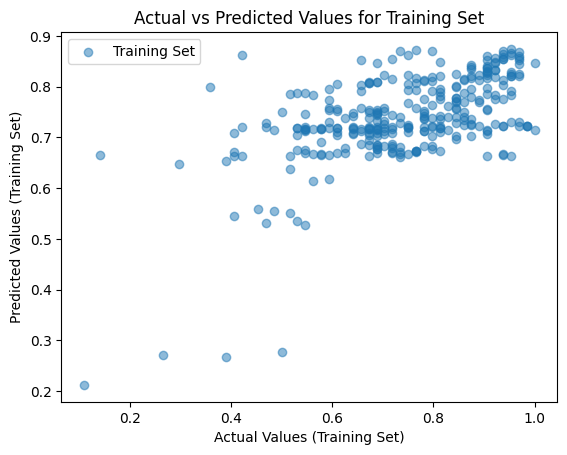

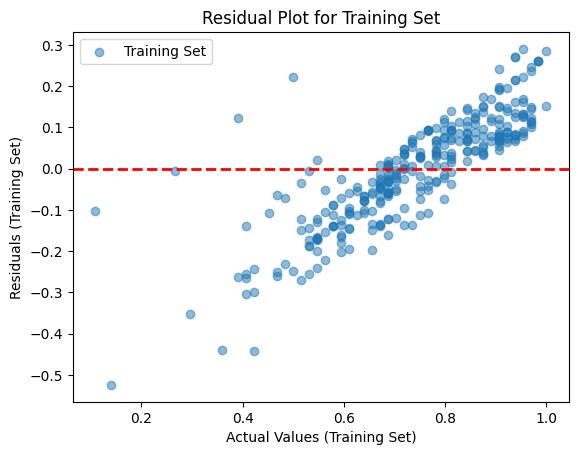

Metrics for Test set:
  MSE: 0.0156
  RMSE: 0.1250
  MAE: 0.1020
  R^2: 0.5480

Metrics for Training set:
  MSE: 0.0170
  RMSE: 0.1305
  MAE: 0.1039
  R^2: 0.3328



In [20]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


Metrics for Test set:
  MSE: 0.0150
  RMSE: 0.1223
  MAE: 0.1014
  R^2: 0.5675

Metrics for Training set:
  MSE: 0.0160
  RMSE: 0.1267
  MAE: 0.0993
  R^2: 0.3717



In [16]:
# Define a grid of points for prediction (including X, Y, and Z)
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 60)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 6)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(60, 6, 100)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)


fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='BrBG_r',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y_test.data.numpy().ravel(),
        colorscale='BrBG_r',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y_test.data.numpy().ravel()]

))



fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
fig.write_html('tmp.html', auto_open=True)
